In [ ]:
import pandas as pd
import numpy as np  
import networkx as nx
import matplotlib.pyplot as plt
import json
import pickle
from datetime import datetime
from collections import defaultdict
import os
import time
os.chdir("D:/uppsala/16. data of social mining/data")

# STEP 1：加载 tweets.dat

In [49]:
def load_tweets(file_path="tweets.dat"):
    records = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                t = json.loads(line)
            except:
                continue

            tweet_id = t.get("id")
            author_id = t.get("author_id")
            text = t.get("text", "")

            created_at_str = t.get("created_at")
            timestamp = None
            if created_at_str:
                timestamp = datetime.fromisoformat(
                    created_at_str.replace("Z", "+00:00") #原始格式: 2021-09-01T12:34:56.000Z，转换为ISO 8601格式
                )

            # -------- URL + domain ---------
            urls, domains = [], []
            ents = t.get("entities", {})
            if ents and "urls" in ents:
                for u in ents["urls"]:
                    exp = u.get("expanded_url") # url是缩短的，expanded_url是完整的，https://twitter.com/unfoundation/status/675764967111544833
                    if exp:
                        urls.append(exp)
                        try:
                            dom = exp.split("/")[2].replace("www.", "") # 提取域名，去除www.
                            domains.append(dom)
                        except:
                            pass

            records.append({
                "tweet_id": tweet_id,
                "author_id": author_id,
                "text": text,
                "timestamp": timestamp,
                "urls": urls,
                "domains": domains
            })

    df = pd.DataFrame(records)
    print("Loaded tweets:", len(df))
    return df


# STEP 2：构建 co-action network
*  co-action 的定义是：两个账号在 s 秒内发布了同一个 url → 算一次 co-action
* R_type: "url" or "domain"

* s 秒窗口

* r 最少共同行为次数阈值

* filter_retweets 是否过滤 RT

In [84]:
def generate_coaction_network(df, R_type="url", s=1, r=2, filter_retweets=True):

    entity_col = "urls" if R_type == "url" else "domains"
    df = df.copy()

    # -------- 是否过滤 retweets --------
    if filter_retweets:
        print("Filtering retweets (RT)...")
        df = df.loc[~df["text"].str.startswith("RT")]
    else:
        print("Keeping retweets (RT included)...")

    # -------- 保留有 entity 的推文 --------
    df = df[df[entity_col].apply(bool)]

    # -------- 计算 entity 频数 --------
    s_ent = pd.Series([e for lst in df[entity_col] for e in lst])
    ent_freq = s_ent.value_counts()
    
    # -------- 过滤只出现5次的 entity --------
    frequent_ents = set(ent_freq[ent_freq > 5].index)

    df[entity_col] = df[entity_col].apply(lambda lst: [e for e in lst if e in frequent_ents])
    df = df[df[entity_col].apply(bool)]

    # -------- 展开每条 entity --------
    df_ex = df[["author_id", "timestamp", entity_col]].explode(entity_col)
    df_ex = df_ex.rename(columns={entity_col: "ent"})

    df_ex = df_ex.sort_values(["ent", "timestamp"])

    # -------- 滑动窗口 --------
    from collections import defaultdict
    co_counts = defaultdict(int)

    for ent, grp in df_ex.groupby("ent"):
        arr_acc = grp["author_id"].to_numpy()
        arr_ts = grp["timestamp"].to_numpy()
        n = len(arr_acc)
        left = 0

        for right in range(n):
            while arr_ts[right] - arr_ts[left] > pd.Timedelta(seconds=s):
                left += 1

            for i in range(left, right):
                a = arr_acc[i]
                b = arr_acc[right]
                if a != b:
                    co_counts[(a, b)] += 1

    # -------- 构建图 --------
    import networkx as nx
    G = nx.Graph()
    for (a, b), cnt in co_counts.items():
        if cnt >= r:
            G.add_edge(a, b, weight=cnt)

    print("Graph built:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")
    return G


# STEP 3：评估网络是否“reasonable”

* 密度> 0.01 → ❌
* vg_deg > 10 → ❌
* giant component 占比 > 85% → ❌

In [ ]:
def describe_graph_full(G, name="network"):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    density = nx.density(G)

    comps = list(nx.connected_components(G))
    components = len(comps)

    giant = len(max(comps, key=len)) if components else 0
    giant_ratio = giant / n if n > 0 else 0

    degrees = np.array([d for _, d in G.degree()])
    avg_deg = degrees.mean() if len(degrees) else 0

    # ---- 判断 reasonable ----
    too_dense = density > 0.01
    too_high_degree = avg_deg > 10
    overly_connected = giant_ratio > 0.85
    reasonable = not (too_dense or too_high_degree or overly_connected)

    print(f"\n📊 [{name}]")
    print(f"Nodes={n}, Edges={m}")
    print(f"Density={density:.6f}, Avg deg={avg_deg:.2f}")
    print(f"Components={components}, Giant ratio={giant_ratio:.2%}")
    print("Reasonable:", "YES 👍" if reasonable else "NO ❌")

    return {
        "name": name,
        "n": n,
        "m": m,
        "density": density,
        "avg_degree": avg_deg,
        "components": components,
        "giant_ratio": giant_ratio,
        "reasonable": reasonable
    }


# STEP 4：生成 identify bots的网络

* network 1：bot detection → R="url", s=1–3, r=2

<!-- * network 2：ideology detection → R="domain", s 很大（600–1800 秒），r=1 -->

In [52]:
# ---- 加载数据 ----
tweets = load_tweets("tweets.dat")

Loaded tweets: 2260916


In [53]:
print(tweets.head())

             tweet_id   author_id  \
0  675827469119832066  1011975294   
1  675827469006581760   255144027   
2  675827468775718912   214748274   
3  675827465378504705   449273927   
4  675827465336434688  1601937732   

                                                text  \
0  RT @MinisterTdB: Climate change won’t stop ove...   
1  RT @LaurenceTubiana: I just can believe it !we...   
2  RT @COP21en: We did it! #ParisAgreement is ado...   
3  RT @TheGlobalGoals: Incredible news for our wo...   
4  RT @StopShenhua: “The people’s resolve is such...   

                  timestamp  \
0 2015-12-12 23:59:59+00:00   
1 2015-12-12 23:59:59+00:00   
2 2015-12-12 23:59:59+00:00   
3 2015-12-12 23:59:58+00:00   
4 2015-12-12 23:59:58+00:00   

                                                urls        domains  
0                                                 []             []  
1                                                 []             []  
2  [https://twitter.com/COP21en/status/6757

* 设置不同参数，比较 co-action 的网络合理性

In [ ]:
param_settings = [("url", s, 2) for s in range(1, 11)]


results = []
for R, s, r in param_settings:
    G = generate_coaction_network(tweets, R_type=R, s=s, r=r, filter_retweets=True)
    res = describe_graph_full(G, name=f"{R}_s{s}_r{r}")
    results.append(res)

results = pd.DataFrame(results)

STEP 1: Filtering retweets...
STEP 2: Filtering empty url lists...
STEP 3: Count URL frequencies...
Total unique URLs: 402346
URLs with freq = 1: 347150
Remaining URLs after freq>1 filter: 55196
STEP 4: Filtering df by frequent URLs...
Tweets after URL filtering: 350888
STEP 5: Exploding URLs...
Rows after explode: 388799
STEP 6: Sliding window co-action computing...
STEP 7: Building graph...
Graph built: 954 nodes, 1153 edges

📊 [url_s1_r2]
Nodes=954, Edges=1153
Density=0.002536, Avg deg=2.42
Components=329, Giant ratio=5.35%
Reasonable: YES 👍
STEP 1: Filtering retweets...
STEP 2: Filtering empty url lists...
STEP 3: Count URL frequencies...
Total unique URLs: 402346
URLs with freq = 1: 347150
Remaining URLs after freq>1 filter: 55196
STEP 4: Filtering df by frequent URLs...
Tweets after URL filtering: 350888
STEP 5: Exploding URLs...
Rows after explode: 388799
STEP 6: Sliding window co-action computing...
STEP 7: Building graph...
Graph built: 1035 nodes, 1261 edges

📊 [url_s2_r2]
No

In [70]:
print(results)

         name     n     m   density  avg_degree  components  giant_ratio  \
0   url_s1_r2   954  1153  0.002536    2.417191         329     0.053459   
1   url_s2_r2  1035  1261  0.002357    2.436715         349     0.052174   
2   url_s3_r2  1109  1363  0.002218    2.458070         373     0.049594   
3   url_s4_r2  1161  1453  0.002158    2.503015         387     0.047373   
4   url_s5_r2  1201  1517  0.002105    2.526228         396     0.045795   
5   url_s6_r2  1249  1582  0.002030    2.533227         411     0.045637   
6   url_s7_r2  1281  1636  0.001996    2.554254         418     0.044496   
7   url_s8_r2  1317  1699  0.001961    2.580106         425     0.044039   
8   url_s9_r2  1361  1761  0.001903    2.587803         435     0.043350   
9  url_s10_r2  1422  1843  0.001824    2.592124         450     0.042897   

   reasonable  
0        True  
1        True  
2        True  
3        True  
4        True  
5        True  
6        True  
7        True  
8        True  
9  

In [ ]:
param_settings = [("url", 1, s) for s in range(2, 11)]


results = []
for R, s, r in param_settings:
    G = generate_coaction_network(tweets, R_type=R, s=s, r=r, filter_retweets=True)
    res = describe_graph_full(G, name=f"{R}_s{s}_r{r}")
    results.append(res)

results = pd.DataFrame(results)

STEP 1: Filtering retweets...
STEP 2: Filtering empty url lists...
STEP 3: Count URL frequencies...
Total unique URLs: 402346
URLs with freq = 1: 347150
Remaining URLs after freq>1 filter: 55196
STEP 4: Filtering df by frequent URLs...
Tweets after URL filtering: 350888
STEP 5: Exploding URLs...
Rows after explode: 388799
STEP 6: Sliding window co-action computing...
STEP 7: Building graph...
Graph built: 954 nodes, 1153 edges

📊 [url_s1_r2]
Nodes=954, Edges=1153
Density=0.002536, Avg deg=2.42
Components=329, Giant ratio=5.35%
Reasonable: YES 👍
STEP 1: Filtering retweets...
STEP 2: Filtering empty url lists...
STEP 3: Count URL frequencies...
Total unique URLs: 402346
URLs with freq = 1: 347150
Remaining URLs after freq>1 filter: 55196
STEP 4: Filtering df by frequent URLs...
Tweets after URL filtering: 350888
STEP 5: Exploding URLs...
Rows after explode: 388799
STEP 6: Sliding window co-action computing...
STEP 7: Building graph...
Graph built: 544 nodes, 717 edges

📊 [url_s1_r3]
Node

In [74]:
print(results)
# ---- 判断 reasonable ----
# too_dense = density > 0.01
# too_high_degree = avg_deg > 10
# overly_connected = giant_ratio > 0.85

         name    n     m   density  avg_degree  components  giant_ratio  \
0   url_s1_r2  954  1153  0.002536    2.417191         329     0.053459   
1   url_s1_r3  544   717  0.004855    2.636029         182     0.055147   
2   url_s1_r4  392   584  0.007620    2.979592         127     0.071429   
3   url_s1_r5  299   492  0.011044    3.290970          93     0.070234   
4   url_s1_r6  229   412  0.015782    3.598253          67     0.069869   
5   url_s1_r7  208   360  0.016722    3.461538          63     0.072115   
6   url_s1_r8  174   287  0.019069    3.298851          52     0.086207   
7   url_s1_r9  143   214  0.021078    2.993007          45     0.104895   
8  url_s1_r10  120   187  0.026190    3.116667          37     0.125000   

   reasonable  
0        True  
1        True  
2        True  
3       False  
4       False  
5       False  
6       False  
7       False  
8       False  


In [81]:
# ----  生成 bot network ----
t0 = time.perf_counter()

G_bot= generate_coaction_network(
    tweets,
    R_type="url",
    s=1,
    r=2,
    filter_retweets=True)
t1 = time.perf_counter()
print(f"Elapsed: {t1-t0:.2f} s")

Filtering retweets (RT)...
Graph built: 954 nodes, 1153 edges
Elapsed: 10.38 s


In [77]:
type(G_bot)

networkx.classes.graph.Graph

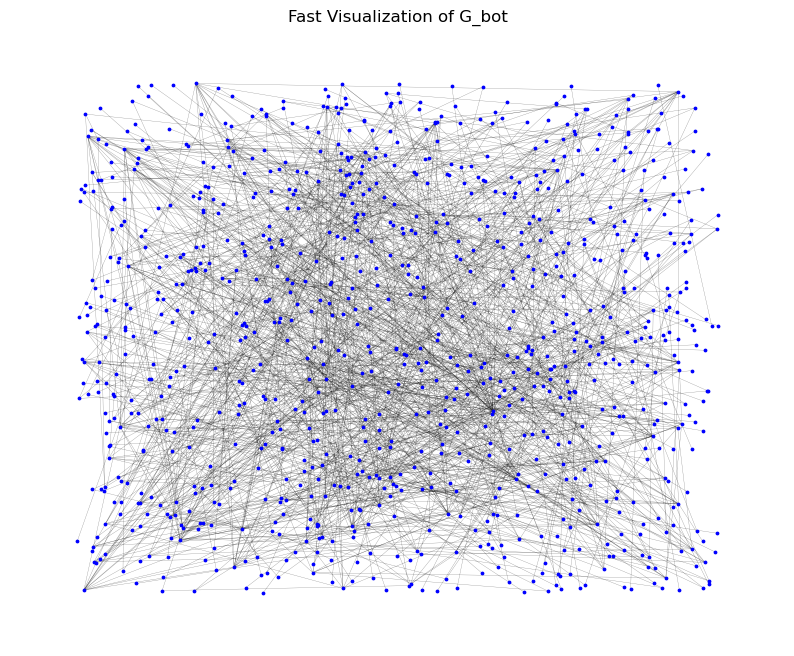

In [78]:
plt.figure(figsize=(10, 8))

pos = nx.random_layout(G_bot)

nx.draw_networkx_nodes(G_bot, pos, node_size=3, node_color="blue")
nx.draw_networkx_edges(G_bot, pos, width=0.2, alpha=0.5)

plt.title("Fast Visualization of G_bot")
plt.axis("off")
plt.show()

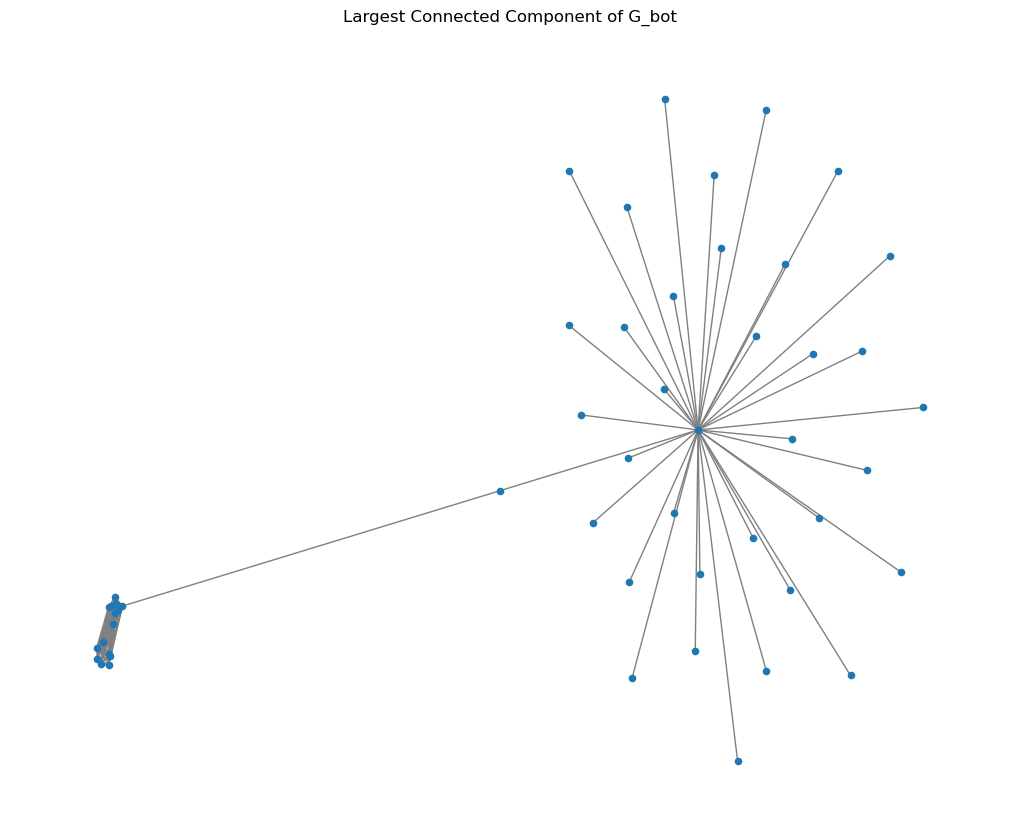

In [79]:
# 最大连通子图
largest_cc = max(nx.connected_components(G_bot), key=len)
G_big = G_bot.subgraph(largest_cc).copy()

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_big, seed=42)
nx.draw(G_big, pos, node_size=20, edge_color="gray", with_labels=False)
plt.title("Largest Connected Component of G_bot")
plt.show()

* There is a micro-group that is only weakly connected to the bot cluster,like a secondary bot cluster
* But they interact only once or very rarely with the central hub account,
* leading to a single long bridge connecting them to the main component. 
They co-post the same URLs within the time window,resulting in a tight mini-cluster
 

# STEP 5：生成  ideology dection的网络


* network 2：ideology detection → R="domain", s 很大（600–1800 秒），r=2

In [ ]:

from urllib.parse import urlparse

def count_domain_frequency(tweets, filter_retweets=True):
    """
    统计 tweets 数据中的 domain 频率
    tweets: DataFrame，包含 'text' 和 'urls' 列
    filter_retweets: 是否过滤以 RT 开头的推文（默认为 True）
    """

    df = tweets.copy()

    # ---- 过滤 retweets ----
    if filter_retweets:
        df = df.loc[~df["text"].str.startswith("RT")]

    # ---- 保留有 URL 的推文 ----
    df = df[df["urls"].apply(bool)]

    # ---- 将 URL 列展平 ----
    all_urls = [url for url_list in df["urls"] for url in url_list]

    # ---- 提取 domain ----
    domains = []
    for u in all_urls:
        try:
            dom = urlparse(u).netloc.replace("www.", "")
            if dom:
                domains.append(dom)
        except:
            pass

    # ---- 频数统计 ----
    domain_freq = pd.Series(domains).value_counts()

    return domain_freq


In [87]:
domain_freq = count_domain_frequency(tweets)
print(domain_freq)

twitter.com                    286654
bit.ly                         190673
ow.ly                           22442
goo.gl                          11763
fb.me                           11618
                                ...  
worldenergypolicysummit.com         1
m.dailytelegraph.com.au             1
scer.govspace.gov.au                1
gbccc.org                           1
trentbrown.in                       1
Name: count, Length: 17293, dtype: int64


In [89]:
domain_freq_5 = domain_freq[domain_freq <= 5]
domain_freq_5

libertepolitique.com           5
abitcoop.it                    5
s.si.edu                       5
globaldaily.com                5
thebea.st                      5
                              ..
worldenergypolicysummit.com    1
m.dailytelegraph.com.au        1
scer.govspace.gov.au           1
gbccc.org                      1
trentbrown.in                  1
Name: count, Length: 14052, dtype: int64

In [85]:
t0 = time.perf_counter()

G_ide = generate_coaction_network(
    tweets, 
    R_type="domain", 
    s=30, 
    r=2, 
    filter_retweets=False)

t1 = time.perf_counter()
print(f"Elapsed: {t1-t0:.2f} s")

Keeping retweets (RT included)...
Graph built: 196367 nodes, 3003271 edges
Elapsed: 96.90 s


In [97]:
# domain + 时间戳 =[10,30, 100]+ 互动次数2
results = []

param_settings_domain = [("domain", s, 2) for s in [10,30, 100]]

for R, s, r in param_settings_domain:
    print(f"\n=== Running {R}, s={s}, r={r} ===")
    G = generate_coaction_network(
        tweets,
        R_type=R,
        s=s,
        r=r,
        filter_retweets=False
    )
    res = describe_graph_full(G, name=f"{R}_s{s}_r{r}")
    results.append(res)
# ---- convert dataframe ----
results = pd.DataFrame(results)
print(results)



=== Running domain, s=10, r=2 ===
Keeping retweets (RT included)...
Graph built: 154454 nodes, 954556 edges

📊 [domain_s10_r2]
Nodes=154454, Edges=954556
Density=0.000080, Avg deg=12.36
Components=983, Giant ratio=98.51%
Reasonable: NO ❌

=== Running domain, s=30, r=2 ===
Keeping retweets (RT included)...
Graph built: 196367 nodes, 3003271 edges

📊 [domain_s30_r2]
Nodes=196367, Edges=3003271
Density=0.000156, Avg deg=30.59
Components=360, Giant ratio=99.55%
Reasonable: NO ❌

=== Running domain, s=100, r=2 ===
Keeping retweets (RT included)...
Graph built: 230113 nodes, 10684129 edges

📊 [domain_s100_r2]
Nodes=230113, Edges=10684129
Density=0.000404, Avg deg=92.86
Components=202, Giant ratio=99.78%
Reasonable: NO ❌
             name       n         m   density  avg_degree  components  \
0   domain_s10_r2  154454    954556  0.000080   12.360392         983   
1   domain_s30_r2  196367   3003271  0.000156   30.588347         360   
2  domain_s100_r2  230113  10684129  0.000404   92.85984

In [98]:
# domain + 时间戳 =100+ 互动次数[5,10,15]

results = []

param_settings_ideo = [
    ("domain", 100, 5),
    ("domain", 100, 10),
    ("domain", 100, 15),
]
for R, s, r in param_settings_ideo:
    print(f"\n=== Running {R}, s={s}, r={r} ===")
    G = generate_coaction_network(
        tweets,
        R_type=R,
        s=s,
        r=r,
        filter_retweets=False
    )
    res = describe_graph_full(G, name=f"{R}_s{s}_r{r}")
    results.append(res)
results = pd.DataFrame(results)
print(results)


=== Running domain, s=100, r=5 ===
Keeping retweets (RT included)...
Graph built: 133310 nodes, 1246332 edges

📊 [domain_s100_r5]
Nodes=133310, Edges=1246332
Density=0.000140, Avg deg=18.70
Components=74, Giant ratio=99.85%
Reasonable: NO ❌

=== Running domain, s=100, r=10 ===
Keeping retweets (RT included)...
Graph built: 59915 nodes, 312439 edges

📊 [domain_s100_r10]
Nodes=59915, Edges=312439
Density=0.000174, Avg deg=10.43
Components=102, Giant ratio=99.57%
Reasonable: NO ❌

=== Running domain, s=100, r=15 ===
Keeping retweets (RT included)...
Graph built: 37179 nodes, 141609 edges

📊 [domain_s100_r15]
Nodes=37179, Edges=141609
Density=0.000205, Avg deg=7.62
Components=142, Giant ratio=99.01%
Reasonable: NO ❌
              name       n        m   density  avg_degree  components  \
0   domain_s100_r5  133310  1246332  0.000140   18.698252          74   
1  domain_s100_r10   59915   312439  0.000174   10.429408         102   
2  domain_s100_r15   37179   141609  0.000205    7.617687 

In [99]:
# 使用url + 过滤掉 retweets
results = []

param_settings_ideo = [
    ("url", 30, 5),
    ("url", 60, 10),
    ("url", 100, 15),
]
for R, s, r in param_settings_ideo:
    print(f"\n=== Running {R}, s={s}, r={r} ===")
    G = generate_coaction_network(
        tweets,
        R_type=R,
        s=s,
        r=r,
        filter_retweets=False
    )
    res = describe_graph_full(G, name=f"{R}_s{s}_r{r}")
    results.append(res)
results = pd.DataFrame(results)
print(results)


=== Running url, s=30, r=5 ===
Keeping retweets (RT included)...
Graph built: 4659 nodes, 8512 edges

📊 [url_s30_r5]
Nodes=4659, Edges=8512
Density=0.000784, Avg deg=3.65
Components=1114, Giant ratio=25.80%
Reasonable: YES 👍

=== Running url, s=60, r=10 ===
Keeping retweets (RT included)...
Graph built: 4063 nodes, 8456 edges

📊 [url_s60_r10]
Nodes=4063, Edges=8456
Density=0.001025, Avg deg=4.16
Components=886, Giant ratio=30.89%
Reasonable: YES 👍

=== Running url, s=100, r=15 ===
Keeping retweets (RT included)...
Graph built: 3859 nodes, 8626 edges

📊 [url_s100_r15]
Nodes=3859, Edges=8626
Density=0.001159, Avg deg=4.47
Components=777, Giant ratio=34.34%
Reasonable: YES 👍
           name     n     m   density  avg_degree  components  giant_ratio  \
0    url_s30_r5  4659  8512  0.000784    3.654003        1114     0.257995   
1   url_s60_r10  4063  8456  0.001025    4.162442         886     0.308885   
2  url_s100_r15  3859  8626  0.001159    4.470588         777     0.343353   

   re

In [100]:
results = pd.DataFrame(results)
print(results)

           name     n     m   density  avg_degree  components  giant_ratio  \
0    url_s30_r5  4659  8512  0.000784    3.654003        1114     0.257995   
1   url_s60_r10  4063  8456  0.001025    4.162442         886     0.308885   
2  url_s100_r15  3859  8626  0.001159    4.470588         777     0.343353   

   reasonable  
0        True  
1        True  
2        True  


In [101]:
# 使用url + 过滤掉 retweets
results = []

param_settings_ideo = [
    ("url", 300, 5),
    ("url", 600, 5),
    ("url", 1000, 5),
]
for R, s, r in param_settings_ideo:
    print(f"\n=== Running {R}, s={s}, r={r} ===")
    G = generate_coaction_network(
        tweets,
        R_type=R,
        s=s,
        r=r,
        filter_retweets=False
    )
    res = describe_graph_full(G, name=f"{R}_s{s}_r{r}")
    results.append(res)
results = pd.DataFrame(results)
print(results)


=== Running url, s=300, r=5 ===
Keeping retweets (RT included)...
Graph built: 11628 nodes, 53176 edges

📊 [url_s300_r5]
Nodes=11628, Edges=53176
Density=0.000787, Avg deg=9.15
Components=1407, Giant ratio=60.94%
Reasonable: YES 👍

=== Running url, s=600, r=5 ===
Keeping retweets (RT included)...
Graph built: 14541 nodes, 86922 edges

📊 [url_s600_r5]
Nodes=14541, Edges=86922
Density=0.000822, Avg deg=11.96
Components=1304, Giant ratio=70.16%
Reasonable: NO ❌

=== Running url, s=1000, r=5 ===
Keeping retweets (RT included)...
Graph built: 17227 nodes, 119252 edges

📊 [url_s1000_r5]
Nodes=17227, Edges=119252
Density=0.000804, Avg deg=13.84
Components=1199, Giant ratio=76.02%
Reasonable: NO ❌
           name      n       m   density  avg_degree  components  giant_ratio  \
0   url_s300_r5  11628   53176  0.000787    9.146199        1407     0.609391   
1   url_s600_r5  14541   86922  0.000822   11.955436        1304     0.701602   
2  url_s1000_r5  17227  119252  0.000804   13.844779     

In [ ]:
# ---- 生成最终的 ideology detection networks ----
G_ide = generate_coaction_network(
    tweets, 
    R_type="domain", 
    s=300, 
    r=5, 
    filter_retweets=False)

# TIPS & QUESTIONS:

1.  Think of whether you should consider or not retweets to generate this network.
    * In the **Bot network**, retweets must be excluded.For example,if A, B, and C all retweet the same BBC tweet within seconds,they are just normal users pressing the RT button
    * In the **ideology/topical network**, retweets should NOT be removed.Our goal is to find groups who have similar interests.Retweets  show  people endorsement,perference.

2. When you choose the filters (the type of entity R, the time interval s, and the number of required co-actions r), try to identify values leading to "reasonable" networks: if the resulting network is too dense, it may take too long to analyse it and (most importantly) the network structure may not be usable as a proxy to identify bots and/or ideology.
    we generated networks remain sparse, interpretable, and structurally meaningful.
    * density > 0.01,the graph becomes almost fully connected，the network can no longer serve as a proxy for bot or ideology analysis
    * too_high_degree = avg_deg > 10,every node is tied to too many others，resulting network behaves like a near-clique
    * overly_connected = giant_ratio > 0.85,giant component overwhelms the structur
    
3. Use the code you wrote last week, for example the one generating an overview of the network structure, to decide good parameter settings.
    * Done
4. Can you use any knowledge you have learned during the first seminar (week one) to decide which entities to use to define the ideology network?
    * URL